In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from tokenizers import Tokenizer, models, trainers, pre_tokenizers
import pandas as pd
import re
import random
import os
import csv
import json
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    print(f"Using CUDA. Device: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Using CPU.")

Using CUDA. Device: NVIDIA A100-SXM4-40GB


#Data PreProcessing

In [4]:
from transformers import AutoTokenizer
tokenizer_en_to_ht = AutoTokenizer.from_pretrained("bert-base-uncased")
tokenizer_ht_to_en = AutoTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


#Hyperparamteres

In [5]:
# Hyperparameters
batch_size = 128 # This defines the number of samples processed in one forward/backward pass of the model.
block_size = 16  # sequence length || This represents the length of the input sequences the model will process.
max_iters = 5000 # This sets the maximum number of training iterations (or steps) the model will perform.
                 # The training will stop after this many iterations, even if other stopping criteria haven't been met.
eval_interval = 100 # This determines how often the model's performance is evaluated during training.
learning_rate = 1e-3 # This controls the step size at each iteration while moving toward a minimum of the loss function.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 128 #  Refers to the dimensionality of the embedding space.
n_hidden = 256
dropout = 0.2 # Dropout is a regularization technique to prevent overfitting.
num_epochs = 10

#Data Preparation

In [6]:
with open('/content/drive/My Drive/tokenized_en_ht.json', 'r') as f:
    tokenized_en_ht = json.load(f)

with open('/content/drive/My Drive/tokenized_ht_en.json', 'r') as f:
    tokenized_ht_en = json.load(f)

# First, let's examine the structure of your data
print("Sample of tokenized_en_ht:", tokenized_en_ht[:2])
print("Type of first element:", type(tokenized_en_ht[0]))

# Modified code to find maximum token value
max_token_en_ht = max(max(tokens) if isinstance(tokens, list) else tokens for tokens in tokenized_en_ht)
max_token_ht_en = max(max(tokens) if isinstance(tokens, list) else tokens for tokens in tokenized_ht_en)

print(f"Maximum token value in en_ht dataset: {max_token_en_ht}")
print(f"Maximum token value in ht_en dataset: {max_token_ht_en}")

def get_vocab_size(tokenized_data):
    vocab_set = set()
    for tokens in tokenized_data:
        vocab_set.update(tokens)
    return len(vocab_set)

# Vocab sizes for English-to-Haitian
input_vocab_size_en_to_ht = get_vocab_size(tokenized_en_ht)
output_vocab_size_en_to_ht = get_vocab_size(tokenized_ht_en)

# Vocab sizes for Haitian-to-English
input_vocab_size_ht_to_en = get_vocab_size(tokenized_ht_en)
output_vocab_size_ht_to_en = get_vocab_size(tokenized_en_ht)

print(f"Input vocab size for English-to-Haitian: {input_vocab_size_en_to_ht}, Output vocab size: {output_vocab_size_en_to_ht}")
print(f"Input vocab size for Haitian-to-English: {input_vocab_size_ht_to_en}, Output vocab size: {output_vocab_size_ht_to_en}")

Sample of tokenized_en_ht: [[101, 1026, 1055, 1028, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1026, 4372, 1028, 2507, 2093, 10247, 2005, 6595, 7965, 1012, 1026, 1013, 4372, 1028, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
Type of first element: <class 'list'>
Maximum token value in en_ht dataset: 29611
Maximum token value in ht_en dataset: 29611
Input vocab size for English-to-Haitian: 19666, Output vocab size: 19666
Input vocab size for Haitian-to-English: 19666, Output vocab size: 19666


In [7]:
#Splitting data for train and val

total_subset_size = 20000
train_ratio = 0.8  # 80% for training
val_ratio = 0.2    # 20% for validation

# Shuffle the data
random.seed(42)
random.shuffle(tokenized_en_ht)
random.shuffle(tokenized_ht_en)

#Subset of data
subset_en_ht = tokenized_en_ht[:total_subset_size]
subset_ht_en = tokenized_ht_en[:total_subset_size]

# Calculate the split indices for the subsets
train_size_en_ht = int(total_subset_size * train_ratio)
train_size_ht_en = int(total_subset_size * train_ratio)

# Split the subsetted data
train_data_en_to_ht = subset_en_ht[:train_size_en_ht]
val_data_en_to_ht = subset_en_ht[train_size_en_ht:]

train_data_ht_to_en = subset_ht_en[:train_size_ht_en]
val_data_ht_to_en = subset_ht_en[train_size_ht_en:]

print(f"Training data (en_to_ht): {len(train_data_en_to_ht)} sentences")
print(f"Validation data (en_to_ht): {len(val_data_en_to_ht)} sentences")
print(f"Training data (ht_to_en): {len(train_data_ht_to_en)} sentences")
print(f"Validation data (ht_to_en): {len(val_data_ht_to_en)} sentences")


Training data (en_to_ht): 16000 sentences
Validation data (en_to_ht): 4000 sentences
Training data (ht_to_en): 16000 sentences
Validation data (ht_to_en): 4000 sentences


#Model

In [8]:
class LSTMTranslator(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, embed_size, hidden_size, dropout):
        super(LSTMTranslator, self).__init__()
        self.embedding = nn.Embedding(input_vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=2, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_vocab_size)

    def forward(self, input_seq):
        embedded = self.embedding(input_seq)
        output, (hidden, cell) = self.lstm(embedded)
        output = self.fc(output)
        return output

In [9]:
def get_batch(split, lang_pair):
    if lang_pair == 'en_to_ht':

        data = train_data_en_to_ht if split == 'train' else val_data_en_to_ht
    elif lang_pair == 'ht_to_en':
        data = train_data_ht_to_en if split == 'train' else val_data_ht_to_en
    else:
        raise ValueError("Invalid language pair")

    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.tensor([[min(token, vocab_size - 1) for token in data[i][:block_size]]
        for i in ix
    ], dtype=torch.long)

    y = torch.tensor([
        [min(token, vocab_size - 1) for token in data[i][1:block_size+1]]
        for i in ix
    ], dtype=torch.long)
    return x.to(device), y.to(device)


In [10]:
@torch.no_grad()
def estimate_loss(model, criterion, eval_iters, device):
    out = {}
    model.eval()

    # For both language pairs (en-to-ht and ht-to-en)
    for lang_pair in ['en_to_ht', 'ht_to_en']:
        losses = torch.zeros(eval_iters, device=device)

        for k in range(eval_iters):
            X, Y = get_batch('train', lang_pair)
            output = model(X)  # Forward pass
            B, T, V = output.shape
            loss = criterion(output.view(B * T, V), Y.view(B * T))  # Calculate loss
            losses[k] = loss.item()

        out[lang_pair] = losses.mean()

    model.train()
    return out


In [11]:
def generate_predictions(model, val_data, tokenizer, max_length=50, device='cuda', batch_size=32):

    model.eval()
    predictions = []

    # Process in batches
    for i in range(0, len(val_data), batch_size):
        batch = val_data[i:i + batch_size]

        # Convert batch to tensors
        if isinstance(batch[0], list):
            batch_tokens = torch.tensor(batch).to(device)
        else:
            # If input needs tokenization
            batch_tokens = torch.tensor([
                tokenizer.encode(sent, padding='max_length', max_length=max_length, truncation=True)
                for sent in batch
            ]).to(device)

        with torch.no_grad():
            outputs = model(batch_tokens)
            pred_tokens = outputs.argmax(dim=-1)

            # Decode predictions
            for pred in pred_tokens:
                try:
                    pred_text = tokenizer.decode(pred.tolist(), skip_special_tokens=True).strip()
                    predictions.append(pred_text if pred_text else "")
                except Exception as e:
                    print(f"Error decoding prediction: {e}")
                    predictions.append("")


    return predictions



#Training

In [12]:
#maximum token value + 2(for padding)
vocab_size = 29611 + 2

#Model Definition
model_en_to_ht = LSTMTranslator(vocab_size, vocab_size, embed_size=128, hidden_size=256, dropout=0.1).to(device)
model_ht_to_en = LSTMTranslator(vocab_size, vocab_size, embed_size=128, hidden_size=256, dropout=0.1).to(device)

optimizer_en_to_ht = torch.optim.Adam(model_en_to_ht.parameters(), lr=learning_rate)
optimizer_ht_to_en = torch.optim.Adam(model_ht_to_en.parameters(), lr=learning_rate)

criterion = nn.CrossEntropyLoss()


In [13]:
pip install sacrebleu

In [14]:
import sacrebleu
import numpy as np

# Preparing the CSV files
loss_csv_file_path = '/content/drive/My Drive/lstm_losses.csv'
with open(loss_csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['epoch', 'avg_train_loss_en_to_ht', 'avg_train_loss_ht_to_en',
                    'avg_val_loss_en_to_ht', 'avg_val_loss_ht_to_en'])

bleu_file_path = '/content/drive/My Drive/bleu_scores.csv'
with open(bleu_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['epoch', 'avg_bleu_en_to_ht', 'avg_bleu_ht_to_en'])

chrf_file_path = '/content/drive/My Drive/chrf_scores.csv'
with open(chrf_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['epoch', 'avg_chrf_en_to_ht', 'avg_chrf_ht_to_en'])

# Training loop
for epoch in range(num_epochs):
    model_en_to_ht.train()
    model_ht_to_en.train()

    num_batches = len(train_data_en_to_ht) // batch_size

    epoch_train_losses_en_ht = []
    epoch_train_losses_ht_en = []
    epoch_val_losses_en_ht = []
    epoch_val_losses_ht_en = []
    epoch_bleu_en_ht = []
    epoch_bleu_ht_en = []
    epoch_chrf_en_ht = []
    epoch_chrf_ht_en = []

    for batch_idx in range(num_batches):
        # Training for en-to-ht
        X, Y = get_batch('train', lang_pair='en_to_ht')
        optimizer_en_to_ht.zero_grad()
        output = model_en_to_ht(X)
        B, T, V = output.shape
        train_loss_en_ht = criterion(output.view(B * T, V), Y.view(B * T))
        train_loss_en_ht.backward()
        optimizer_en_to_ht.step()
        epoch_train_losses_en_ht.append(train_loss_en_ht.item())

        # Training for ht-to-en
        X, Y = get_batch('train', lang_pair='ht_to_en')
        optimizer_ht_to_en.zero_grad()
        output = model_ht_to_en(X)
        B, T, V = output.shape
        train_loss_ht_en = criterion(output.view(B * T, V), Y.view(B * T))
        train_loss_ht_en.backward()
        optimizer_ht_to_en.step()
        epoch_train_losses_ht_en.append(train_loss_ht_en.item())


        # Evaluation phase at intervals
        if batch_idx % eval_interval == 0:
            model_en_to_ht.eval()
            model_ht_to_en.eval()

            with torch.no_grad():
                # Validation losses
                losses_en_to_ht = estimate_loss(model_en_to_ht, criterion, eval_iters, device)
                losses_ht_to_en = estimate_loss(model_ht_to_en, criterion, eval_iters, device)

                val_loss_en_ht = losses_en_to_ht['en_to_ht']
                val_loss_ht_en = losses_ht_to_en['ht_to_en']

                if isinstance(val_loss_en_ht, torch.Tensor):
                    val_loss_en_ht = val_loss_en_ht.cpu().item()
                if isinstance(val_loss_ht_en, torch.Tensor):
                    val_loss_ht_en = val_loss_ht_en.cpu().item()

                epoch_val_losses_en_ht.append(val_loss_en_ht)
                epoch_val_losses_ht_en.append(val_loss_ht_en)

                # Generating predictions for evaluation
                eval_sample_size = 100
                val_data_en_to_ht_sampled = val_data_en_to_ht[:eval_sample_size]
                val_data_ht_to_en_sampled = val_data_ht_to_en[:eval_sample_size]

                predictions_en_to_ht = generate_predictions(model_en_to_ht, val_data_en_to_ht_sampled, tokenizer_en_to_ht, max_length=50, device=device)
                predictions_ht_to_en = generate_predictions(model_ht_to_en, val_data_ht_to_en_sampled, tokenizer_ht_to_en, max_length=50, device=device)

                predictions_en_to_ht = [str(pred) if pred else "" for pred in predictions_en_to_ht]
                predictions_ht_to_en = [str(pred) if pred else "" for pred in predictions_ht_to_en]

                references_en_to_ht = [[str(ref)] for ref in val_data_en_to_ht_sampled]
                references_ht_to_en = [[str(ref)] for ref in val_data_ht_to_en_sampled]

                # Calculating metrics
                bleu_en_to_ht = sacrebleu.corpus_bleu(predictions_en_to_ht, references_en_to_ht).score
                bleu_ht_to_en = sacrebleu.corpus_bleu(predictions_ht_to_en, references_ht_to_en).score
                epoch_bleu_en_ht.append(bleu_en_to_ht)
                epoch_bleu_ht_en.append(bleu_ht_to_en)

                chrf_en_to_ht = sacrebleu.corpus_chrf(predictions_en_to_ht, [str(ref[0]) for ref in references_en_to_ht]).score
                chrf_ht_to_en = sacrebleu.corpus_chrf(predictions_ht_to_en, [str(ref[0]) for ref in references_ht_to_en]).score
                epoch_chrf_en_ht.append(chrf_en_to_ht)
                epoch_chrf_ht_en.append(chrf_ht_to_en)

            model_en_to_ht.train()
            model_ht_to_en.train()

    # Calculating epoch averages
    avg_train_loss_en_ht = np.mean(epoch_train_losses_en_ht)
    avg_train_loss_ht_en = np.mean(epoch_train_losses_ht_en)
    avg_val_loss_en_ht = np.mean(epoch_val_losses_en_ht)
    avg_val_loss_ht_en = np.mean(epoch_val_losses_ht_en)
    avg_bleu_en_ht = np.mean(epoch_bleu_en_ht)
    avg_bleu_ht_en = np.mean(epoch_bleu_ht_en)
    avg_chrf_en_ht = np.mean(epoch_chrf_en_ht)
    avg_chrf_ht_en = np.mean(epoch_chrf_ht_en)


    print(f"\nEpoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss - En->Ht: {avg_train_loss_en_ht:.4f}, Ht->En: {avg_train_loss_ht_en:.4f}")
    print(f"Val Loss - En->Ht: {avg_val_loss_en_ht:.4f}, Ht->En: {avg_val_loss_ht_en:.4f}")
    print(f"BLEU Score - En->Ht: {avg_bleu_en_ht:.2f}", f"BLEU Score - Ht->En: {avg_bleu_ht_en:.2f}")
    print(f"CHRF Score - En->Ht: {avg_chrf_en_ht:.2f}", f"CHRF Score - Ht->En: {avg_chrf_ht_en:.2f}")


    with open(loss_csv_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch,
                        avg_train_loss_en_ht, avg_train_loss_ht_en,
                        avg_val_loss_en_ht, avg_val_loss_ht_en])

    with open(bleu_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch, avg_bleu_en_ht, avg_bleu_ht_en])

    with open(chrf_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch, avg_chrf_en_ht, avg_chrf_ht_en])

# Save the final models
torch.save(model_en_to_ht.state_dict(), '/content/drive/My Drive/model_en_to_ht.pth')
torch.save(model_ht_to_en.state_dict(), '/content/drive/My Drive/model_ht_to_en.pth')


Epoch 1/10:
Train Loss - En->Ht: 2.5620, Ht->En: 2.5262
Val Loss - En->Ht: 5.8082, Ht->En: 5.7785
BLEU Score - En->Ht: 0.00 BLEU Score - Ht->En: 0.55
CHRF Score - En->Ht: 3.63 CHRF Score - Ht->En: 4.12

Epoch 2/10:
Train Loss - En->Ht: 1.2343, Ht->En: 1.1706
Val Loss - En->Ht: 1.2793, Ht->En: 1.2703
BLEU Score - En->Ht: 0.00 BLEU Score - Ht->En: 0.09
CHRF Score - En->Ht: 4.67 CHRF Score - Ht->En: 2.55

Epoch 3/10:
Train Loss - En->Ht: 0.6871, Ht->En: 0.6700
Val Loss - En->Ht: 0.7196, Ht->En: 0.7118
BLEU Score - En->Ht: 0.00 BLEU Score - Ht->En: 0.17
CHRF Score - En->Ht: 3.00 CHRF Score - Ht->En: 2.02

Epoch 4/10:
Train Loss - En->Ht: 0.4221, Ht->En: 0.4211
Val Loss - En->Ht: 0.4370, Ht->En: 0.4322
BLEU Score - En->Ht: 0.00 BLEU Score - Ht->En: 0.16
CHRF Score - En->Ht: 2.80 CHRF Score - Ht->En: 2.48

Epoch 5/10:
Train Loss - En->Ht: 0.2763, Ht->En: 0.2738
Val Loss - En->Ht: 0.2839, Ht->En: 0.2734
BLEU Score - En->Ht: 0.00 BLEU Score - Ht->En: 0.14
CHRF Score - En->Ht: 2.60 CHRF Score 

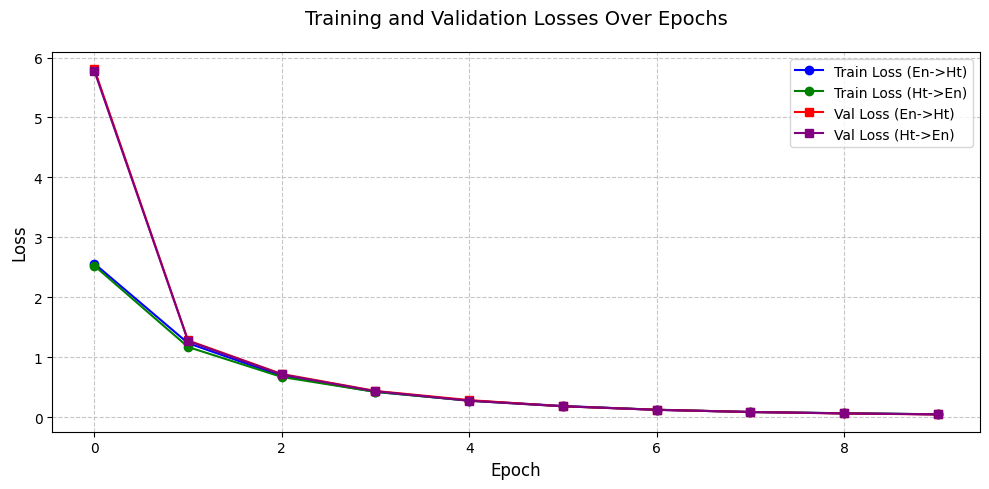

In [17]:
#Training and Validation Plot
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/lstm_losses.csv')

plt.figure(figsize=(10, 5))

# Plot training losses
plt.plot(df['epoch'], df['avg_train_loss_en_to_ht'], marker='o', label='Train Loss (En->Ht)', color='blue')
plt.plot(df['epoch'], df['avg_train_loss_ht_to_en'], marker='o', label='Train Loss (Ht->En)', color='green')

# Plot validation losses
plt.plot(df['epoch'], df['avg_val_loss_en_to_ht'], marker='s', label='Val Loss (En->Ht)', color='red')
plt.plot(df['epoch'], df['avg_val_loss_ht_to_en'], marker='s', label='Val Loss (Ht->En)', color='purple')

plt.title('Training and Validation Losses Over Epochs', pad=20, size=14)
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()
